In [269]:
import os
import sys
import torch

### 파이토치 3D 라이브러리 설치
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


In [270]:
import os
import torch
import numpy as np

## 진행률 시각화 도구
from tqdm.notebook import tqdm

## 데이터 시각화 도구
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## obj 파일 로드 및 저장 도구
from pytorch3d.io import load_obj, save_obj

## 삼각형 Meshes간 꼭짓점과 면을 연결하는 함수를 제공
from pytorch3d.structures import Meshes

## 정점과 면을 생성하는 함수를 제공
from pytorch3d.utils import ico_sphere

## Meshes 모둠을 포인트 클라우드
### 포인트 클라우드란?: 3차원 공간상에 퍼져 있는 여러 포인트의 집합을 의미
from pytorch3d.ops import sample_points_from_meshes

## chamfer_distance: chamfer(모따기) [ 포인트 클라우드의 x, y 사이의 거리를 모따기 작업하는 함수 제공 ]
## mesh_edge_loss: 매쉬의 최종 손실을 계산하는 함수 제공
## mesh_laplacian_smoothing: 라플라시안 스무딩 알고리증을 Mesh에 적용하는 한수를 제공
    ### 라플라시안 스무딩: 다각형 Mesh를 매끄럽게하는 알고리즘
### mesh_normal_consistency: Mesh간 일반 일관성을 계산하는 함수를 제공
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
## 딥러닝에 사용되는 디바이스 설정
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [271]:
## 3D(.obj) 파일 다운로드
# !wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

In [272]:
## 다운 받은 obj 파일 경로 가져온다
# trg_obj = os.path.join('Alien Animal.obj')
trg_obj = os.path.join('dolphin.obj')

In [273]:
## 3D 파일 정보를 가져온다
### verts = (V, 3): FloatTensor
    # V: Mesh의 정점의 숫자
### faces = LongTensors contains verts_idx, normals_idx, textures_idx 정보를 가진 객체
verts, faces, aux = load_obj(trg_obj)

### .to => 데이터를 디바이스에 넘긴다
verts_idx = verts.to(device)
faces_idx = faces.verts_idx.to(device)
print(verts_idx)
print(faces_idx)

### 타겟의 mesh를 (0, 0, 0) 좌표에 맞추기 위해 정규화한다.
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
print(f'center: {center}, scale: {scale}')

## Meshes 구조를 이전에 생성한 verts와 faces의 verts_idx로 연결하는 함수
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

tensor([[-0.0374,  0.4473,  0.1219],
        [ 0.0377,  0.4471,  0.1220],
        [-0.0378,  0.2817,  0.0426],
        ...,
        [-0.0220,  0.2618, -0.1531],
        [-0.0226,  0.2818, -0.1400],
        [-0.0271,  0.2740, -0.1376]])
tensor([[   0,  646,  643],
        [   0,  643,  642],
        [   0,  642,  644],
        ...,
        [2536, 2535, 2537],
        [2558, 2556, 2557],
        [2525, 2524, 2523]])
center: tensor([2.3951e-04, 3.4056e-01, 8.8234e-02]), scale: 0.37160244584083557


/Users/tospace01/opt/anaconda3/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:529: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [274]:
## mesh 초기화
src_mesh = ico_sphere(4, device)

/Users/tospace01/opt/anaconda3/lib/python3.9/site-packages/pytorch3d/structures/meshes.py:1107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


/var/folders/yf/mmrj8c9d2zbfn3w8crhhf0_r0000gn/T/ipykernel_97520/2792193850.py:29: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


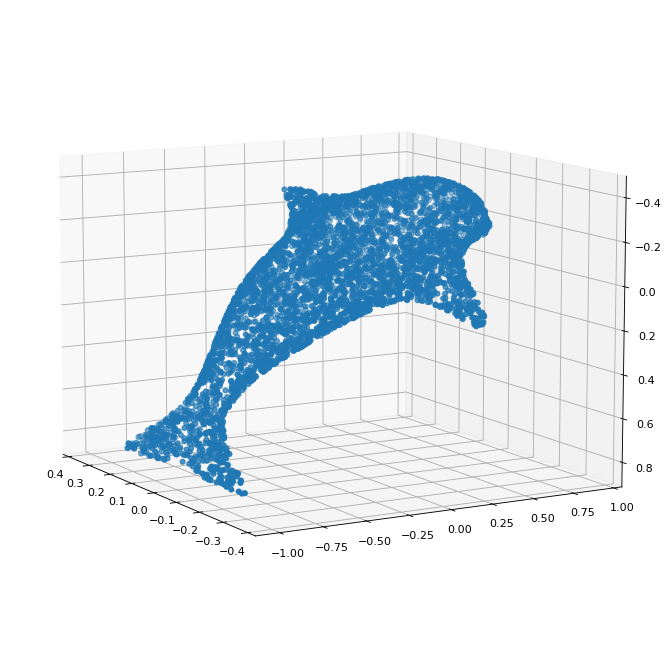

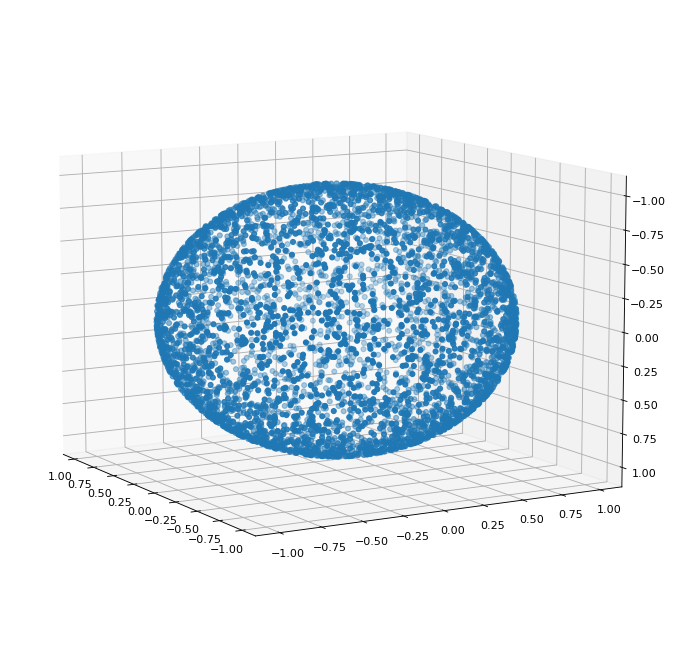

In [275]:
## 생성한 src mesh 시각화
### .clone: 텐서 복사
### .detach: 텐서를 device에서 분리
### .cpu: GPU 메모리에 올려져 있는 tensor를 cpu 메모리로 복사하는 method
### .squeeze: 크기1의 모든 치수가 제거된 텐서를 반환
    # x = torch.zeros(2, 1, 2, 1, 2)
    # x.size() -> torch.Size([2, 1, 2, 1, 2])
    # y = torch.squeeze(x)
    # y.size() -> torch.Size([2, 2, 2])
    # y = torch.squeeze(x, 0)
    # y.size() -> torch.Size([2, 1, 2, 1, 2])
    # y = torch.squeeze(x, 1)
    # y.size() -> torch.Size([2, 2, 1, 2])
### .unbind: 텐서의 치수를 제거
    # torch.unbind(torch.tensor([[1, 2, 3],
    #                            [4, 5, 6],
    #                            [7, 8, 9]]))
    # (tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))

def plot_pointcloud(mesh, title=""):
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)


    ## 그래프 생성 함수
    fig = plt.figure(figsize=(8, 8))

    ## 3D 그래프 생성 함수
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)

    ax.view_init(190, 30) ## 첫 로딩 시 좌표의 초기 뷰 설정
    plt.show() ## 설정된 좌표 생성 함수

plot_pointcloud(trg_mesh, "Target Mesh")
plot_pointcloud(src_mesh, "Source mesh")

In [276]:
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [277]:
## 최적화 객체 생성
optimizer = torch.optim.SGD([ deform_verts ], lr=1.0, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 1.0
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

  0%|          | 0/2000 [00:00<?, ?it/s]

/var/folders/yf/mmrj8c9d2zbfn3w8crhhf0_r0000gn/T/ipykernel_97520/2792193850.py:29: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


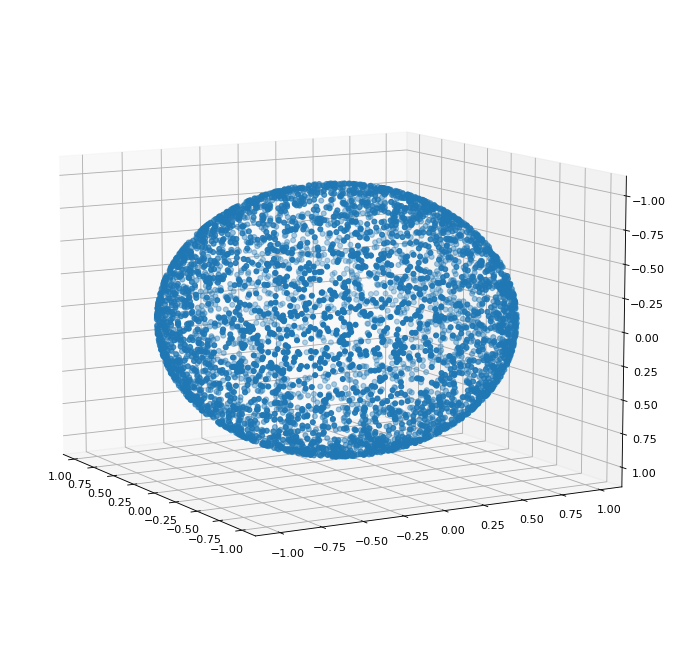

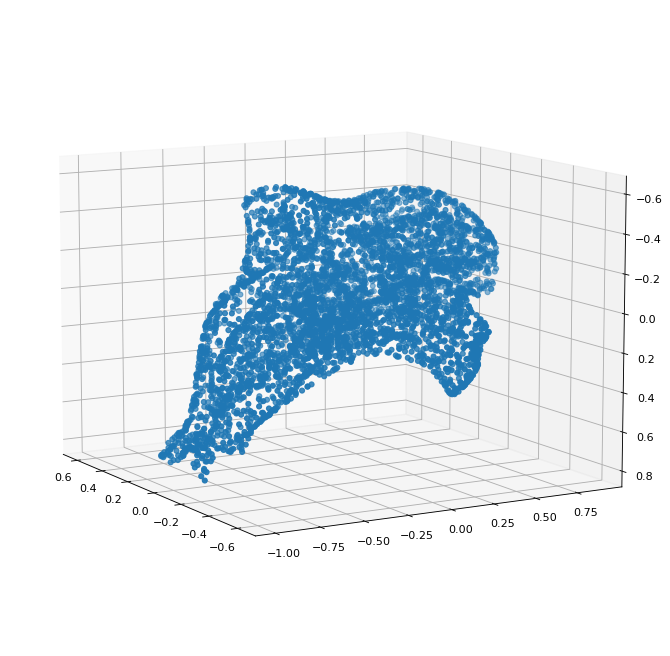

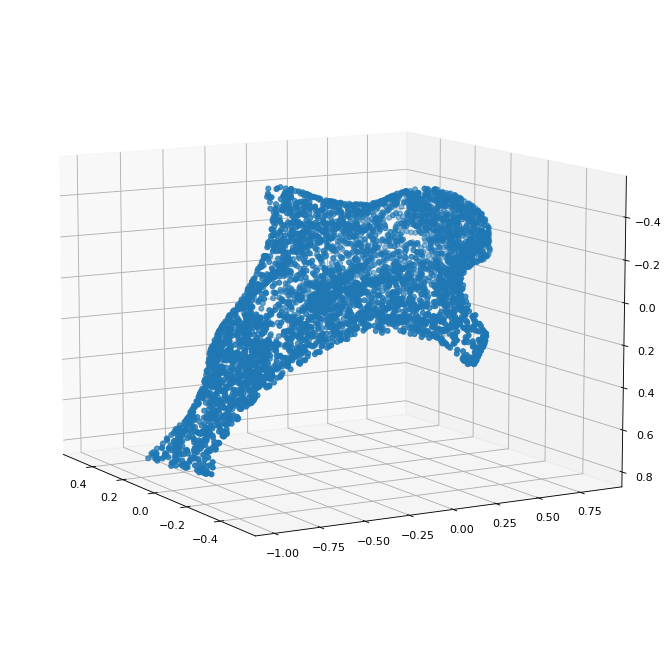

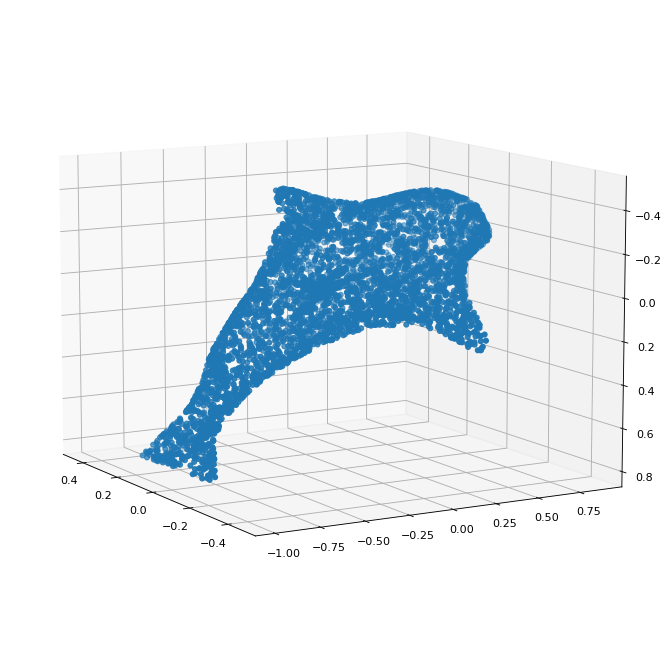

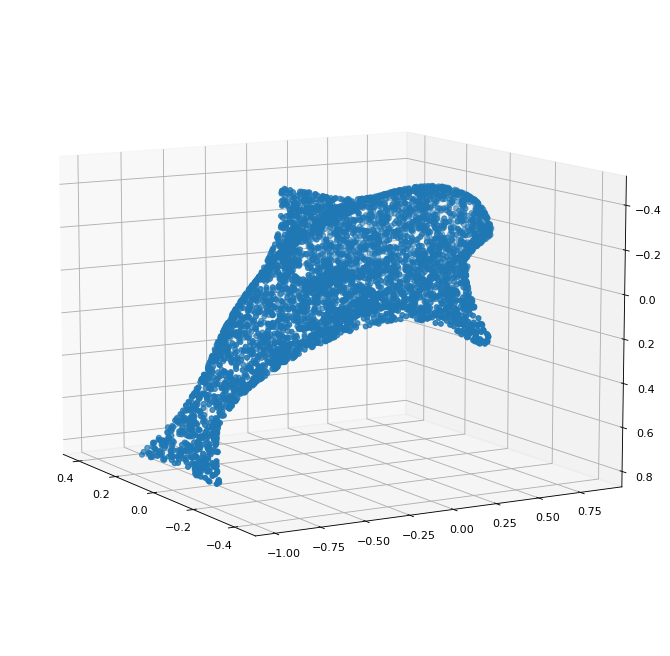

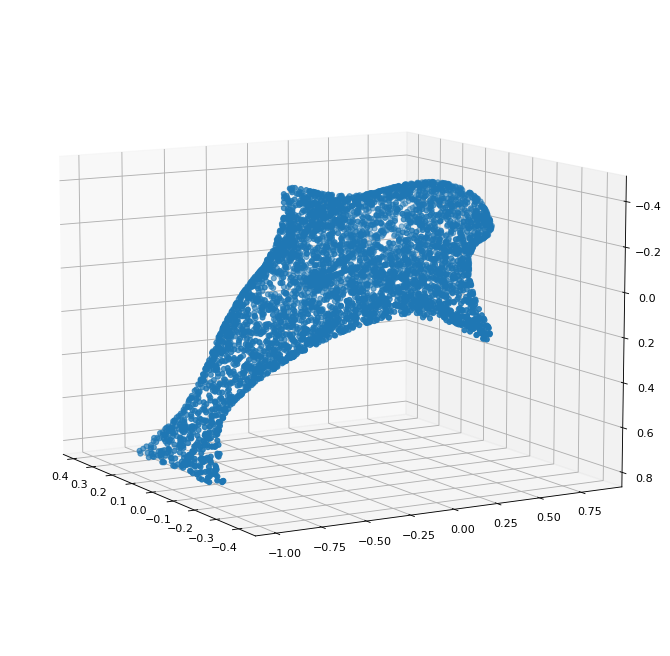

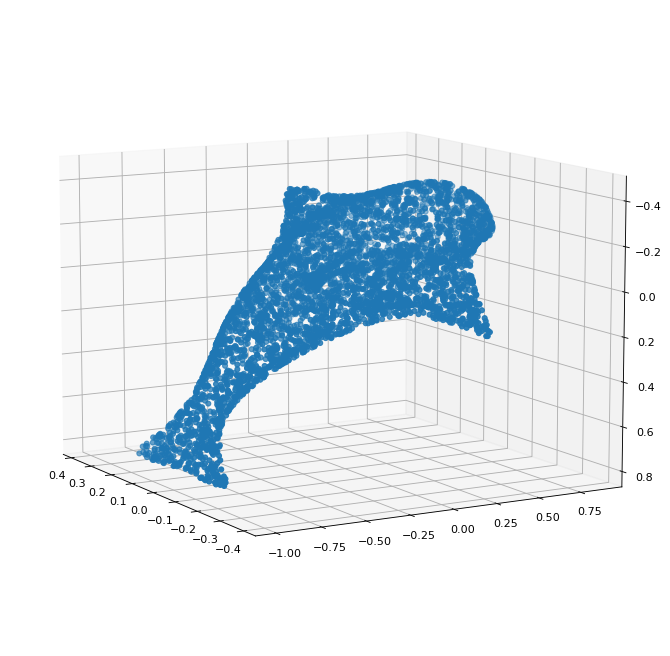

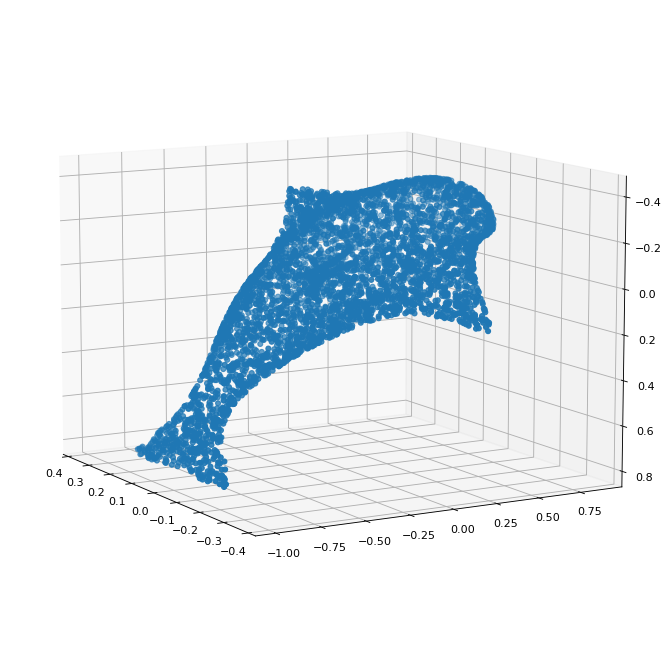

In [278]:
#
Niter = 2000

# 모따기 가중치
w_chamfer = 1.0
chamfer_losses = []

# 모서리 가중치
w_edge = 1.0
edge_losses = []

# 일관성 가중치
w_normal = 0.01
normal_losses = []

# 라플라시안 가중치
w_laplacian = 0.1
laplacian_losses = []

# 손실 반복 구간
plot_period = 250
loop = tqdm(range(Niter))

# %matplotlib inline

for i in loop:
    ## 초기화 함수
    optimizer.zero_grad()

    ## src_mesh와 같은 메쉬 생성
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    ## 타겟 샘플 구체 생성
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    # print(f'sample_trg: {sample_trg}')

    ## 소스 샘플 구체 생성
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    # print(f'sample_src: {sample_src}')

    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    # print(f'loss_chamfer: {loss_chamfer}')

    loss_edge = mesh_edge_loss(new_src_mesh)
    # print(f'loss_edge: {loss_edge}')

    loss_normal = mesh_normal_consistency(new_src_mesh)
    # print(f'loss_normal: {loss_normal}')

    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method='uniform')
    # print(f'loss_laplacian: {loss_laplacian}')

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    loop.set_description('total_loss = %.6f' % loss)

    # 반복 당 각 손실 수집
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))

    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization
    loss.backward()
    optimizer.step()

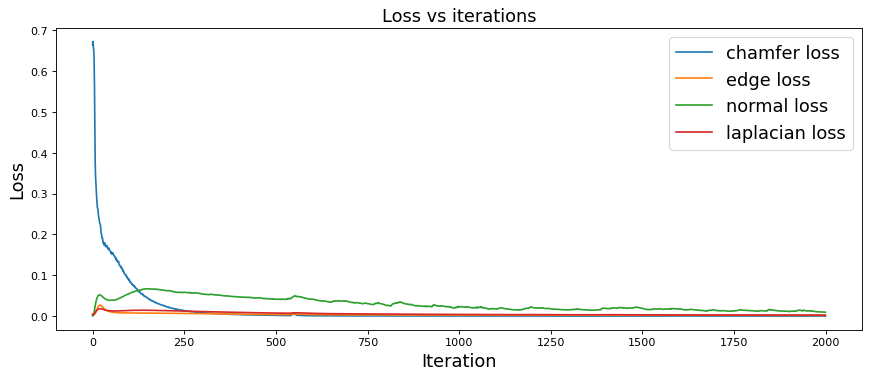

In [279]:
## 손실 함수 그래프
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [280]:
##
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)